# Escolhendo modelos

Dentre uma variedade gigante de modelos, vamos focar em 3: K-Nearest Neighbours (KNN), Suppport Vector Machines (SVM) e Long-short Term Memory Neural Networks (LSTM). As duas primeiras possuem diversas implementações no SkLearn, enquanto que a terceira pode ser usada com o PyTorch. 

Primeiro, vamos criar alguns dados dummy para podermos entender e visualizar o funcionamento dos algoritmos. Abaixo, temos um conjunto de dados com 500 amostras, duas dimensões (características) e três centros (classes).

Aumentando o desvio padrão (**cluster_std**) permite que os clusters fiquem mais esparsos, gerando intersecções entre elas. Vamos usar apenas duas características (**n_feats**) para podermos visualizar o problema.

In [21]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import make_blobs


dummyfeats, dummylbl = make_blobs(n_features=2, n_samples=2000, centers=3, cluster_std=3)

Os dados gerados serão diferentes a cada execução, mas **cluster_std=3** já é o suficiente para garantir alguma interseção entre as amostras. Acima disso já comça a virar bagunça!

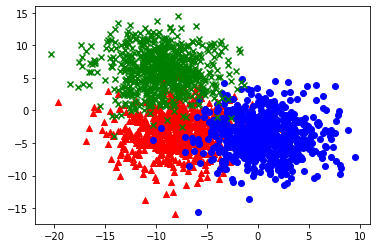

In [3]:
import matplotlib.pyplot as plt

def plot_data(data, lbls):
    c1 = data[lbls == 0]
    c2 = data[lbls == 1]
    c3 = data[lbls == 2]
    plt.scatter(c1[:, 0], c1[:, 1], marker='^', color='red')
    plt.scatter(c2[:, 0], c2[:, 1], marker='o', color='blue')
    plt.scatter(c3[:, 0], c3[:, 1], marker='x', color='green')
plot_data(dummyfeats, dummylbl)

Agora, precisamos dividir os dados em treino e teste. Poderíamos também adicionar um terceiro subconjunto **validação**, mas futuramente usaremos validação cruzada. Lembrando que, a **validação cruzada** permite simular o conjunto de validação quando não temos dados suficientes.

Vamos usar, novamente, o SkLearn para isso. O método abaixo possui várias customizações permitindo sua aplicação em diferentes cenários. Abaixo, a separação mais simples consiste em apenas escolher o tamanho do conjunto de teste (**test_size**)

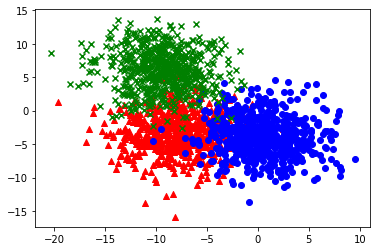

In [4]:
from sklearn.model_selection import train_test_split

dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.1)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

Em alguns casos, principalmente em problemas de identificação, pode ser necessário garantir que todas as classes estejam presentes em ambos os conjuntos. Podemos usar a separação estratificada (**stratify**), mantendo as proporções dos dados de acordo com alguma característica da base.

In [5]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

Por fim, para evitar que seus experimentos sejam tendenciados por ter escolhido um ponto muito no espaço de busca (ou muito ruim) também podemos embaralhar as amostras (**shuffle**). No entanto, acaba sendo desnecessário quando usamos validação cruzada.

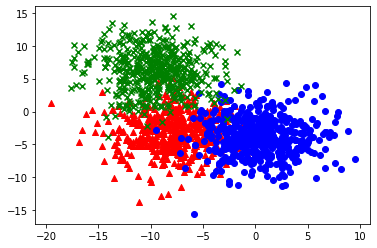

In [6]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl, shuffle=True)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

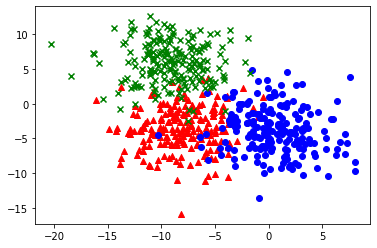

In [7]:
plot_data(dummy_ftest, dummylbl_test)

Com os dados devidamente separados, podemos aplicar ao nosso modelo para treinamento e teste. Vamos usar o KNN para exemplificar o procedimento, e mais na frente fazemos o mesmo de forma resumida para o SVM e o LSTM. Na maioria dos casos, os modelos do SkLearn fazem o treinamento a partir do método **fit**, o teste com o **predict**, os dois com o **fit_predict**, ou também podemos usar o **score** para calcular alguma métrica sobre a predição. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(dummy_ftrain, dummylbl_train)
knn.score(dummy_ftest, dummylbl_test)

0.9083333333333333

Com esses métodos, temos um modelo decente para classificar nossos dados. Mas ainda podemos ir além, pois o knn está usando apenas valores padrões. Embora sejam valores comuns, **não são os melhores!**. Vejamos quantos parâmetros o modelo posssui

In [9]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Temos um total de 8 parâmetros que podem ser ajustados no nosso modelo! Dentre eles, **p**, **n_neighbors** e **weights** podem afetar nossa performance. Vamos aumentar a quantidade de vizinhos e ver qual o efeito disso

In [10]:
knn.set_params(n_neighbors=7)
knn.score(dummy_ftest, dummylbl_test)

0.915

E que tal reduzir pra 1?

In [11]:
knn.set_params(n_neighbors=1)
knn.score(dummy_ftest, dummylbl_test)

0.8733333333333333

E pra 200?

In [12]:
knn.set_params(n_neighbors=200)
knn.score(dummy_ftest, dummylbl_test)

0.9283333333333333

Otimizar os parâmetros assim é bastante trabalhoso e aumenta substancialmente a probabilidade de errarmos ou esquecer alguma coisa no caminho. Para evitar isso, podemos automatizar nossa busca pelo modelo _"ótimo"_ para o nosso problema. Vamos usar uma forma mais simples e ordenada para otmização dos parâmetros: **Grid Search**.

Isso é literalmente criar uma malha (ou uma matriz, se preferir) onde podemos ver cada coluna como valores de parâmetros a serem otimizados, sendo assim as linhas as combinações entre esses parâmetros. Por exemplo, para o knn

In [36]:
from sklearn.model_selection import GridSearchCV

pgrid = [{'n_neighbors': [5, 10, 15, 20], 'p': [1, 2, 3]}]

estimator = KNeighborsClassifier()
gsearch = GridSearchCV(estimator, pgrid, cv=3)
gsearch.fit(dummy_ftrain, dummylbl_train)
cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000982,0.000235,0.022303,0.004815,5,1,"{'n_neighbors': 5, 'p': 1}",0.895075,0.892934,0.896996,0.895001,0.001659,10
1,0.000901,0.000170,0.021693,0.005381,5,2,"{'n_neighbors': 5, 'p': 2}",0.907923,0.882227,0.894850,0.895000,0.010491,11
2,0.000746,0.000036,0.020348,0.000563,5,3,"{'n_neighbors': 5, 'p': 3}",0.907923,0.882227,0.890558,0.893569,0.010704,12
3,0.000662,0.000032,0.018021,0.000399,10,1,"{'n_neighbors': 10, 'p': 1}",0.905782,0.901499,0.899142,0.902141,0.002748,3
4,0.000633,0.000025,0.017353,0.000282,10,2,"{'n_neighbors': 10, 'p': 2}",0.903640,0.897216,0.896996,0.899284,0.003082,8
5,0.000681,0.000025,0.020794,0.000351,10,3,"{'n_neighbors': 10, 'p': 3}",0.905782,0.899358,0.896996,0.900712,0.003712,7
6,0.000716,0.000051,0.018622,0.000279,15,1,"{'n_neighbors': 15, 'p': 1}",0.897216,0.897216,0.896996,0.897143,0.000104,9
7,0.000634,0.000025,0.017948,0.000586,15,2,"{'n_neighbors': 15, 'p': 2}",0.905782,0.901499,0.899142,0.902141,0.002748,3
8,0.000693,0.000048,0.020619,0.000476,15,3,"{'n_neighbors': 15, 'p': 3}",0.910064,0.897216,0.899142,0.902141,0.005658,3
9,0.000686,0.000051,0.019124,0.000445,20,1,"{'n_neighbors': 20, 'p': 1}",0.905782,0.901499,0.899142,0.902141,0.002748,3


O **pgrid** é justamente a matriz de combinações que queremos testar. Note que usamos o parâmetro **cv**, ele permite especificar qual tipo de validação cruzada queremos usar. No exemplo acima, optei por usar uma validação cruzada 3 estratificada.

Em seguida, visualizamos os resultados como um DataFrame. Mas o cv_results é um dicionário com várias informações sobre as execuções! Também podemos ver qual foi a melhor configuração, uma instância do melhor classficador,

In [39]:
print(f'Best conf: {gsearch.best_params_}')
gsearch.best_estimator_

Best conf: {'n_neighbors': 20, 'p': 2}


KNeighborsClassifier(n_neighbors=20)

Agora, com o nosso classificador bombado podemos usá-lo no conjunto de teste!

In [40]:
knn = gsearch.best_estimator_
knn.score(dummy_ftest, dummylbl_test)

0.9166666666666666

Vamos visualizar os resultados de forma mais detalhada usando uma matriz de confusão

[[179  17  11]
 [ 13 182   0]
 [  8   1 189]]


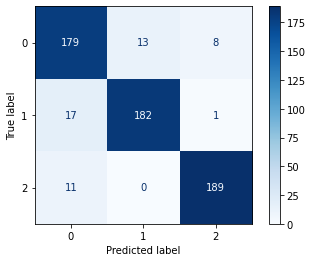

In [46]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

preds = knn.predict(dummy_ftest)
print(confusion_matrix(preds, dummylbl_test))
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Blues')

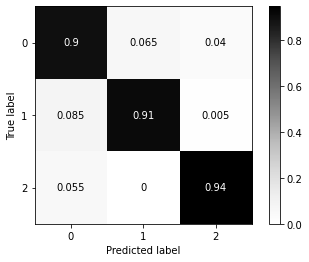

In [51]:
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Greys', normalize='true')

## Adicionano outros modelos para comparação